In [1]:
# standard libraries
import numpy as np #numpy warnings may be safely ignored, known issue.
import pandas as pd
from collections import defaultdict
from math import * # Used for the haversine/distance calculations
import datetime as dt 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for model building
from sklearn.cluster import KMeans

# for optimizations
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Make an empty DefaultDict
# fill dictionary {year: station data}
# build hierarchal dataframe using dictionary

# Example of data location
# https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/2010/NiceRide_station_2010.csv

nr_dict = defaultdict()
for x in [2010 + x for x in range(8)] :
    nr_dict[x] = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                             +str(x)+"/NiceRide_station_"+str(x)+".csv")
nr_station = pd.concat(nr_dict)

In [3]:
# Extracting the most robust year/data set from the total
nr_station_2017 = nr_station.loc[(2017),:]

In [4]:
nr_station_2017.tail()

,Terminal,Station,Latitude,Longitude,Ndocks
196,30199,Hidden Falls Park,44.907001,-93.191432,19
197,30201,Elwood Ave N & Oak Park Ave N,44.987160,-93.301944,15
198,30202,Mill City Quarter,44.980500,-93.261800,23
199,30203,W 50th Street & W Minnehaha Pkwy,44.912125,-93.298552,23
200,30204,NE Central Ave & NE 14th Ave,45.002526,-93.247162,15


## First we'll create a matrix that has the arc distance of each station comparatively.

In [5]:
station_ids = nr_station_2017.Terminal.values # will be used for matrix column names

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    '''
    Haversine definition: will calculate the distance between two points
    using the latitude and longitude of each point.
    '''
    miles_constant = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    mi = miles_constant * c
    return mi

In [7]:
distance = pd.DataFrame(index = station_ids)
for x in range(len(station_ids)) :
    distance[station_ids[x]] = haversine(nr_station_2017.Latitude.values[x], nr_station_2017.Longitude.values[x],\
                            nr_station_2017.Latitude.values, nr_station_2017.Longitude.values)

In [8]:
distance_matrix = np.array(distance.iloc[:,:])

In [9]:
distance.info()
distance.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 30000 to 30204
Columns: 201 entries, 30000 to 30204
dtypes: float64(201)
memory usage: 317.2 KB


,30000,30001,30002,30003,30004,30005,30006,30007,30008,30009,...,30194,30195,30196,30197,30198,30199,30201,30202,30203,30204
30000,0.000000,2.500883,1.466835,2.471107,1.267481,0.304709,1.308283,1.034074,2.514716,0.970652,...,1.792963,1.091036,1.346930,1.120933,0.944879,6.253741,2.223943,0.397380,5.431379,1.301979
30001,2.500883,0.000000,1.062434,4.686271,2.976568,2.642299,2.790346,2.456370,1.899581,1.775162,...,1.178669,1.412001,1.362179,1.653395,1.579928,3.813231,4.358510,2.467683,4.825362,3.331634
30002,1.466835,1.062434,0.000000,3.641812,1.967888,1.648298,1.808542,1.448112,1.612348,0.969751,...,0.977645,0.389264,0.738530,0.920689,0.633325,4.788731,3.322895,1.405513,4.753667,2.470703
30003,2.471107,4.686271,3.641812,0.000000,1.746448,2.564107,1.971116,2.246913,3.718459,3.438583,...,4.236012,3.364533,3.782869,3.585482,3.330279,8.096739,0.361928,2.300340,5.491521,2.988440
30004,1.267481,2.976568,1.967888,1.746448,0.000000,1.530430,0.242315,0.521591,2.057588,2.053101,...,2.722854,1.761634,2.284861,2.171021,1.813986,6.364891,1.399569,0.899256,4.474715,2.429523


In [10]:
# If we wanted to merge our two new dataframes together
# nr_station_2017 = pd.merge(nr_station_2017, distance, left_on='Terminal', right_index=True)

In [11]:
distance_matrix

array([[0.        , 2.50088312, 1.46683481, ..., 0.39738012, 5.43137926,
        1.30197948],
       [2.50088312, 0.        , 1.06243441, ..., 2.46768258, 4.82536183,
        3.33163364],
       [1.46683481, 1.06243441, 0.        , ..., 1.40551251, 4.7536674 ,
        2.47070301],
       ...,
       [0.39738012, 2.46768258, 1.40551251, ..., 0.        , 5.05488421,
        1.68165967],
       [5.43137926, 4.82536183, 4.7536674 , ..., 5.05488421, 0.        ,
        6.73294638],
       [1.30197948, 3.33163364, 2.47070301, ..., 1.68165967, 6.73294638,
        0.        ]])

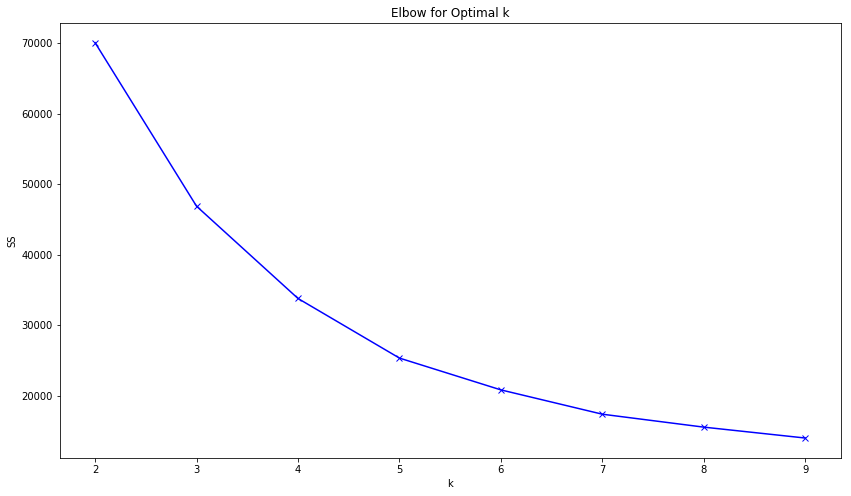

In [12]:
SS = []

# k means determine k
for k in range(2,10) :
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(distance_matrix)

    SS.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(14,8))
plt.plot(range(2,10), SS, 'bx-')
plt.xlabel('k')
plt.ylabel('SS')
plt.title('Elbow for Optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6549918908470278
For n_clusters = 3 The average silhouette_score is : 0.5595209768190251
For n_clusters = 4 The average silhouette_score is : 0.3916531164926617
For n_clusters = 5 The average silhouette_score is : 0.44090868574616987
For n_clusters = 6 The average silhouette_score is : 0.46634457562130993
For n_clusters = 7 The average silhouette_score is : 0.45010199948775736
For n_clusters = 8 The average silhouette_score is : 0.42920354068056776
For n_clusters = 9 The average silhouette_score is : 0.4153325339420753


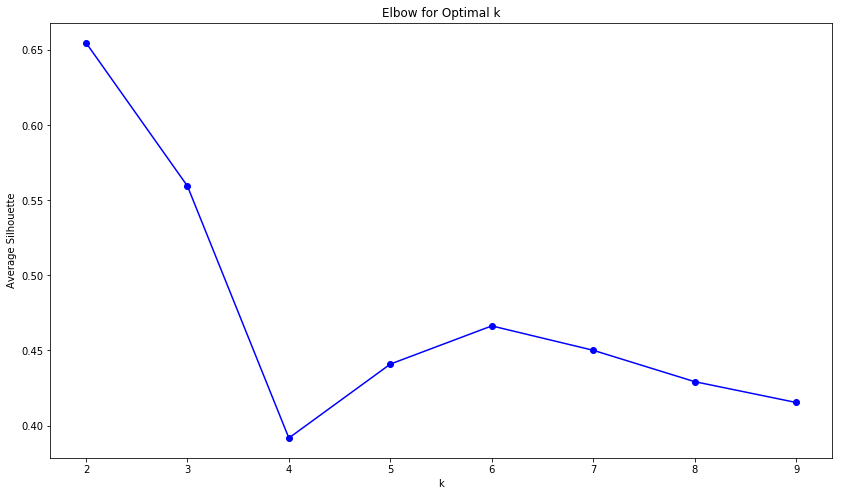

In [13]:
avg_sil = []

#    Compute clustering algorithm (e.g., k-means clustering) for different values of k. For instance, by varying k from 1 to 10 clusters.
for k in range(2,10) :
    clusterer = KMeans(n_clusters=k, random_state=24).fit(distance_matrix)
    cluster_labels = clusterer.labels_
    
#    For each k, calculate the average silhouette of observations (avg.sil).
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    avg_sil.append(silhouette_avg)
    

#    Plot the curve of avg.sil according to the number of clusters k.
plt.figure(figsize=(14,8))
plt.plot(range(2,10), avg_sil, 'bo-')
plt.xlabel('k')
plt.ylabel('Average Silhouette')
plt.title('Elbow for Optimal k')
plt.show()
#    The location of the maximum is considered as the appropriate number of clusters.

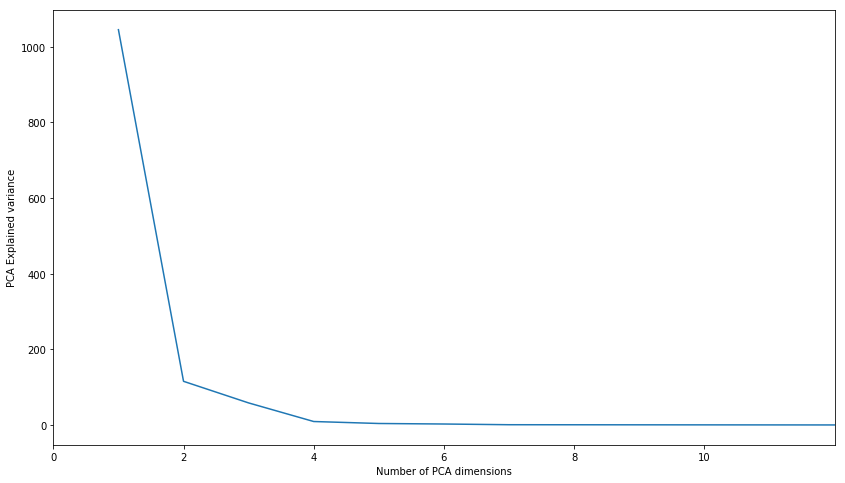

In [14]:
# Initialize a new PCA model with a default number of components.
pca = PCA()
pca.fit(distance_matrix)

plt.figure(figsize=[14,8])
plt.xlim(0,12)
plt.plot(range(1,len(pca.explained_variance_)+1), pca.explained_variance_)
plt.xticks(range(0,12,2))
plt.ylabel('PCA Explained variance')
plt.xlabel('Number of PCA dimensions')
plt.show()

In [15]:
pca_df = pd.DataFrame(PCA(n_components=2).fit_transform(distance_matrix), columns=['x','y'], index=nr_station_2017.index)
pca_df = pd.DataFrame(nr_station_2017.Terminal).join(pca_df)
    # Joins customer names to pca_df containing x-y PCA components
print(pca_df.head())

   Terminal          x          y
0     30000 -23.230553  -5.348980
1     30001  -4.544014 -14.150485
2     30002 -15.734367 -12.502557
3     30003 -21.637575  19.810301
4     30004 -26.821350   3.160106


The ideal dimensionality is 2, and KMeans cluster 6.

In [16]:
def kmeans_plot(pca_df, distance_matrix, x=4) :
    pca_df['cluster']= KMeans(n_clusters=x).fit(distance_matrix).labels_
    sns.lmplot(x='x', y='y', hue='cluster', data=pca_df, fit_reg=False, size=5)

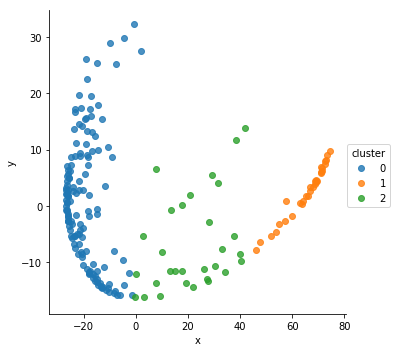

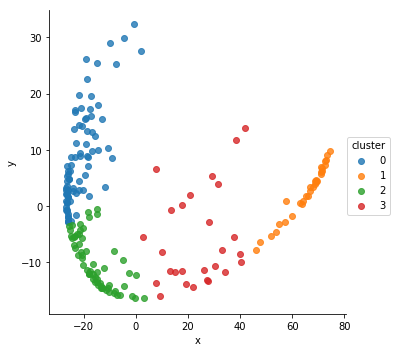

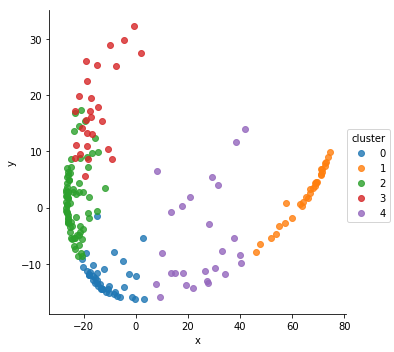

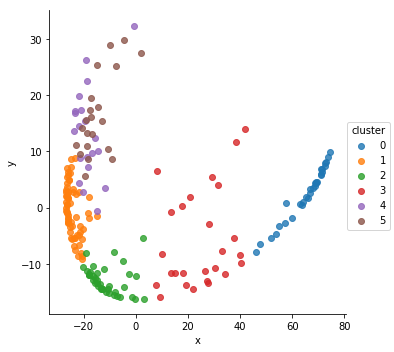

In [17]:
kmeans_plot(pca_df, distance_matrix, 3)
kmeans_plot(pca_df, distance_matrix, 4)
kmeans_plot(pca_df, distance_matrix, 5)
kmeans_plot(pca_df, distance_matrix, 6)

Looking at the graphs: 
* n_clusters=3 possibly over simplified
* n_clusters=4 possible insight
* n_clusters=5 possible insight
* n_clusters=6 possibly over-fitted

In [18]:
pca_df['cluster']= KMeans(n_clusters=4).fit(distance_matrix).labels_
four_nr_clusters = pd.merge(nr_station_2017, pca_df, left_on='Terminal', right_on='Terminal')

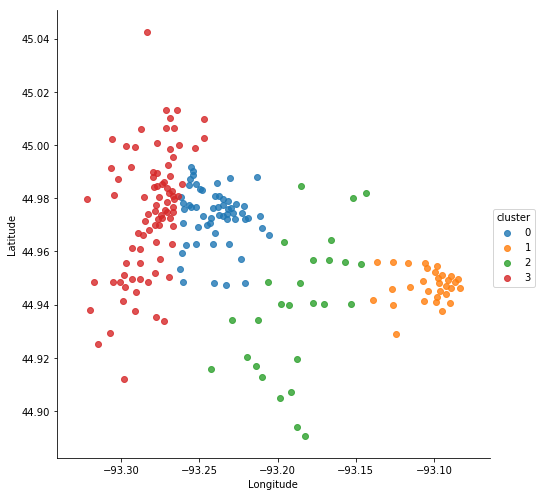

In [19]:
# Stations based on coordinates and clusters
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=four_nr_clusters, fit_reg=False, size=7)

In [20]:
pca_df['cluster']= KMeans(n_clusters=5).fit(distance_matrix).labels_
five_nr_clusters = pd.merge(nr_station_2017, pca_df, left_on='Terminal', right_on='Terminal')

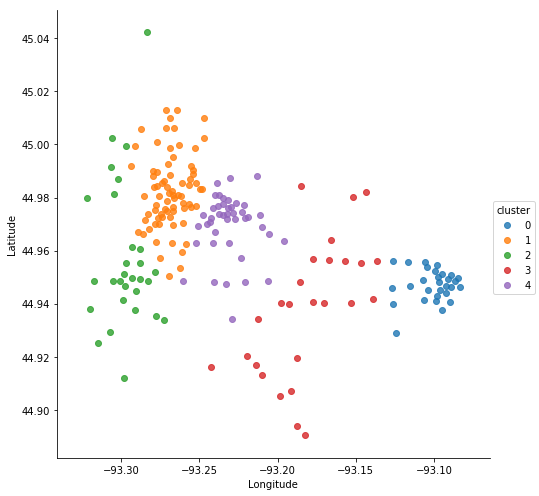

In [21]:
# Stations based on coordinates and clusters
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=five_nr_clusters, fit_reg=False, size=7)

In [22]:
pca_df['cluster']= KMeans(n_clusters=6).fit(distance_matrix).labels_
six_nr_clusters = pd.merge(nr_station_2017, pca_df, left_on='Terminal', right_on='Terminal')

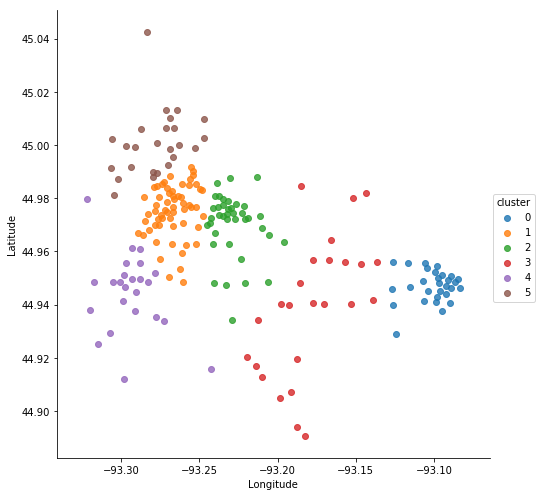

In [23]:
# Stations based on coordinates and clusters
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=six_nr_clusters, fit_reg=False, size=7)

In [24]:
six_nr_clusters.head()

,Terminal,Station,Latitude,Longitude,Ndocks,x,y,cluster
0,30000,100 Main Street SE,44.984892,-93.256551,27,-23.230553,-5.348980,1
1,30001,25th Street & 33rd Ave S,44.957341,-93.223374,15,-4.544014,-14.150485,2
2,30002,Riverside Ave & 23rd Ave S,44.967115,-93.240149,15,-15.734367,-12.502557,2
3,30003,Plymouth Ave N & N Oliver Ave,44.991412,-93.306269,15,-21.637575,19.810301,5
4,30004,11th Street & Hennepin,44.975340,-93.278690,23,-26.821350,3.160106,1


In [25]:
rides_2017 = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/2017/NiceRide_trip_history_2017.csv")

/home/gilmore/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
rides_df = pd.DataFrame(rides_2017)

In [27]:
rides_df.info()
rides_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460716 entries, 0 to 460715
Data columns (total 8 columns):
Start date                  460716 non-null object
Start station               460716 non-null object
Start station ID            460716 non-null object
End date                    460716 non-null object
End station                 460716 non-null object
End station ID              460716 non-null object
Account type                460716 non-null object
Total duration (seconds)    460716 non-null int64
dtypes: int64(1), object(7)
memory usage: 28.1+ MB


,Start date,Start station,Start station ID,End date,End station,End station ID,Account type,Total duration (seconds)
0,11/5/2017 21:45,Hennepin Ave & S Washington Ave,30184,11/5/2017 22:02,Logan Park,30104,Member,1048
1,11/5/2017 21:45,Broadway Street N & 4th Street E,30122,11/5/2017 22:26,Broadway Street N & 4th Street E,30122,Member,2513
2,11/5/2017 21:43,Dale Street & Grand Ave.,30106,11/5/2017 22:13,N Milton Street & Summit Ave,30101,Member,1817
3,11/5/2017 21:41,Weisman Art Museum,30183,11/5/2017 22:05,22nd Ave S & Franklin Ave,30014,Casual,1399
4,11/5/2017 21:38,South 2nd Street & 3rd Ave S,30030,11/5/2017 21:44,6th Ave SE & University Ave,30088,Member,370


## Data prep/cleaning

In [ ]:
rides_df['Start date'] = rides_df['Start date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y %H:%M'))
rides_df['End date'] = rides_df['End date'].apply(lambda x: dt.datetime.strptime(x,'%m/%d/%Y %H:%M'))

In [ ]:
rides_df = rides_df[rides_df['Start station ID'] != 'NRHQ']
rides_df['Start station ID'] = rides_df['Start station ID'].astype(int)
rides_df = rides_df[rides_df['End station ID'] != 'NRHQ']
rides_df['End station ID'] = rides_df['End station ID'].astype(int)

## splitting based on (non-)member

In [ ]:
member = rides_df[rides_df['Account type'] == "Member"]
casual = rides_df[rides_df['Account type'] != "Member"]

In [ ]:
station_member = member[['Start station ID', 'Total duration (seconds)']]
station_member = station_member.groupby(['Start station ID']).count()
station_member = station_member.rename(columns={'Total duration (seconds)':'m_count'})

In [ ]:
casual_member = casual[['Start station ID', 'Total duration (seconds)']]
casual_member = casual_member.groupby(['Start station ID']).count()
casual_member = casual_member.rename(columns={'Total duration (seconds)':'c_count'})

## Merging the data to our clustered dataframe

In [ ]:
six_nr_clusters = pd.merge(six_nr_clusters, station_member, left_on='Terminal', right_on='Start station ID')
six_nr_clusters = pd.merge(six_nr_clusters, casual_member, left_on='Terminal', right_on='Start station ID')

In [ ]:
temp = defaultdict()
for x in np.unique(six_nr_clusters.cluster.values) :
    temp['cluster_'+str(x)] = six_nr_clusters.groupby(six_nr_clusters.cluster==x)[['m_count', 'c_count']].describe()
cluster_describe = pd.concat(temp)
cluster_describe

In [ ]:
six_nr_clusters.head()

In [ ]:
# This will find member mean rides per terminal per cluster
cluster_summary = pd.DataFrame(columns=['terminals', 'tot_rides', 'm_rides', 'c_rides', 'mem_term', \
                                        'cas_term', 'pct_mem_rides'],\
                    index=['Cluster_'+str(x) for x in np.unique(six_nr_clusters.cluster.values)])

for x in np.unique(six_nr_clusters.cluster.values) :
    #build arrays by cluster to work with
    member_array = six_nr_clusters[six_nr_clusters.cluster == x].m_count.values
    casual_array = six_nr_clusters[six_nr_clusters.cluster == x].c_count.values
    total_array = np.sum(member_array) + np.sum(casual_array)
    
    cluster_summary.loc['Cluster_'+str(x), 'terminals'] = len(member_array)
    cluster_summary.loc['Cluster_'+str(x), 'tot_rides'] = member_array.sum() + casual_array.sum()
    cluster_summary.loc['Cluster_'+str(x), 'm_rides'] = member_array.sum()
    cluster_summary.loc['Cluster_'+str(x), 'c_rides'] = casual_array.sum()
    cluster_summary.loc['Cluster_'+str(x), 'mem_term'] = member_array.sum()/len(member_array)
    cluster_summary.loc['Cluster_'+str(x), 'cas_term'] = casual_array.sum()/len(casual_array)
    cluster_summary.loc['Cluster_'+str(x), 'pct_mem_rides'] = (member_array.sum()/total_array.sum())*100

In [ ]:
cluster_summary
# possible to add arc-distance (Lat-Long) square miles

In [ ]:
# Stations based on coordinates and clusters
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=six_nr_clusters, fit_reg=False, size=7)

## Intra-cluster travel
## Trans-cluster travel

## Matrix by station-station travel